In [2]:
# Import the necissary modules
import numpy as np
import obspy
from obspy import Stream
import subprocess as sp
from wipy.wipy_utils import utils
import matplotlib
from matplotlib import pyplot as plt
import scipy
from copy import deepcopy

In [3]:
# Create a List of paths for the feild data files
data_folder = "Field-Data/Acceleration-Data/BW_Line2320_Vertical/"
gahter_names = "Uz_file_single_d.su"

p = sp.run(
    ["ls", data_folder],
    capture_output=True,
    text=True
    )

paths = p.stdout.split("\n")
paths = paths[:-1]  # get rid of empty element at the end of the paths list
print(paths)

['V_S_2320.0_0.0_1_1216.segy', 'V_S_2320.0_0.0_2_1217.segy', 'V_S_2320.0_0.0_3_1219.segy', 'V_S_2320.0_0.0_4_1220.segy', 'V_S_2320.0_0.0_5_1218.segy', 'V_S_2320.0_100.0_1_1337.segy', 'V_S_2320.0_100.0_2_1333.segy', 'V_S_2320.0_100.0_3_1334.segy', 'V_S_2320.0_100.0_4_1335.segy', 'V_S_2320.0_100.0_5_1336.segy', 'V_S_2320.0_10.0_1_1230.segy', 'V_S_2320.0_10.0_2_1227.segy', 'V_S_2320.0_10.0_3_1228.segy', 'V_S_2320.0_10.0_4_1229.segy', 'V_S_2320.0_105.0_1_1343.segy', 'V_S_2320.0_105.0_2_1339.segy', 'V_S_2320.0_105.0_3_1340.segy', 'V_S_2320.0_105.0_4_1341.segy', 'V_S_2320.0_105.0_5_1342.segy', 'V_S_2320.0_110.0_1_1349.segy', 'V_S_2320.0_110.0_2_1345.segy', 'V_S_2320.0_110.0_3_1346.segy', 'V_S_2320.0_110.0_4_1347.segy', 'V_S_2320.0_110.0_5_1348.segy', 'V_S_2320.0_115.0_1_1355.segy', 'V_S_2320.0_115.0_2_1351.segy', 'V_S_2320.0_115.0_3_1352.segy', 'V_S_2320.0_115.0_4_1353.segy', 'V_S_2320.0_115.0_5_1354.segy', 'V_S_2320.0_120.0_1_1363.segy', 'V_S_2320.0_120.0_2_1358.segy', 'V_S_2320.0_120.0_3_1

In [4]:
# pull out the shot locations in accourdance to how Sean Beamis named the files
shot_locs = []
for path in paths:

    shot_loc = path.split("_")[3]
    shot_locs.append(float(shot_loc))

In [5]:
def stack_data(data_folder, paths, shot_locs, s_x):

    # initialize data
    data = obspy.read(data_folder + paths[0], format="segy")

    for trace in data:
        trace.data *= 0.0

    Nt = len(data[0].data)
    dt = data.traces[0].stats.delta

    # stack the data
    for i in range(len(shot_locs)):
        
        if shot_locs[i] == s_x:
            data_sub = obspy.read(data_folder + paths[i], format="segy")
            
            for j in range(len(data)):
                data[j].data += data_sub[j].data

    return Nt, dt, data

In [6]:
Nt, dt, data = stack_data(data_folder, paths, shot_locs, 0.0)

Text(0.5, 1.0, 'Acceleration Data')

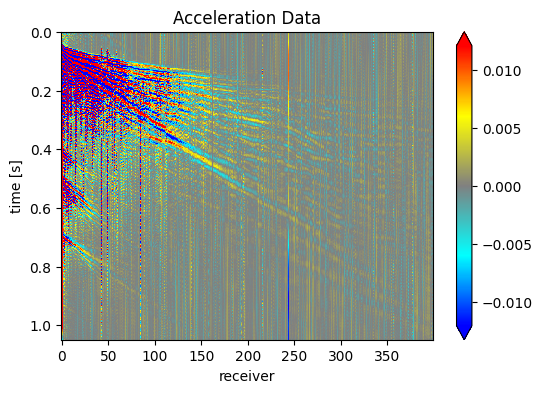

In [7]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
    ["blue", "cyan", "gray", "yellow", "red"])

fig, ax = utils.plot_image(data, 0.001, cmap=cmap)
ax.invert_yaxis()
ax.set_title("Acceleration Data")

(0.0, 80.0)

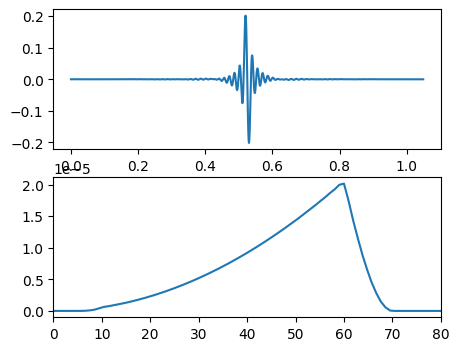

In [11]:
t = np.arange(0, Nt*dt, dt)

# ormsby stf
orms_func = lambda t, t0, f0, f1, f2, f3: \
    ((f0**2)/(f1-f0))*(np.sinc(f0*(t-t0))**2) - \
    ((f1**2)/(f1-f0))*(np.sinc(f1*(t-t0))**2) - \
    ((f2**2)/(f3-f2))*(np.sinc(f2*(t-t0))**2) + \
    ((f3**2)/(f3-f2))*(np.sinc(f3*(t-t0))**2)
f0 = 5
f1 = 10
f2 = 60
f3 = 70
t0 = np.max(t)/2
orms = orms_func(t, t0, f0, f1, f2, f3)
orms /= np.max(np.abs(orms))

# freq, P = scipy.signal.periodogram(orms, 1/dt)

# fig, ax = plt.subplots(2, 1, figsize=(5,4))
# ax[0].plot(t, orms)
# ax[1].plot(freq, P)
# ax[1].set_xlim(0, 80)

# filt = np.zeros(Nt)
# for omega in np.arange(1, 100, 1.0):
#     filt += 2*np.pi*omega*np.cos(2*np.pi*omega*t/np.max(t))
# filt = np.roll(filt, int(Nt/2))

filt = np.hstack([np.array([0]), np.diff(orms)])


freq, P = scipy.signal.periodogram(filt, 1/dt)

fig, ax = plt.subplots(2, 1, figsize=(5,4))
ax[0].plot(t, filt)
ax[1].plot(freq, P)
ax[1].set_xlim(0, 80)


In [21]:
def integrate_data(trace, filt1, filt2):
    Nt = len(trace)
    for i in range(2):
        trace = np.cumsum(np.convolve(trace, filt, "same"))
        # trace = np.convolve(trace, filt2, "same")

    return trace

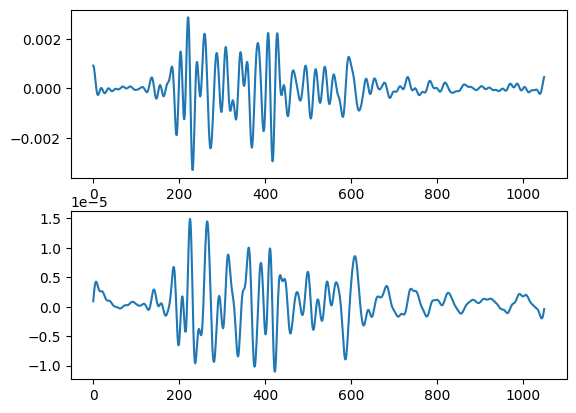

In [22]:
y0 = np.convolve(tr, filt, "same")
y1 = np.cumsum(y0)*dt
# y1 = np.convolve(y1, orms, "same")

plt.subplot(211)
plt.plot(y0)
plt.subplot(212)
plt.plot(y1)


(0.0, 100.0)

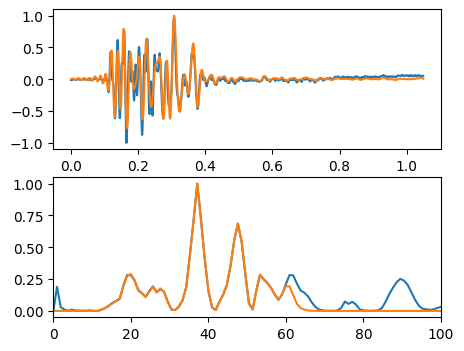

In [25]:
tr = data[100].data

tr_int = integrate_data(tr, filt, orms)

freq, P = scipy.signal.periodogram(tr, 1/dt)
freq, P_int = scipy.signal.periodogram(tr_int, 1/dt)

fig, ax = plt.subplots(2, 1, figsize=(5,4))
ax[0].plot(t, tr/np.max(np.abs(tr)))
ax[0].plot(t, tr_int/np.max(np.abs(tr_int)))
ax[1].plot(freq, P/np.max(P))
ax[1].plot(freq, P_int/np.max(P_int))
ax[1].set_xlim(0, 100)

In [26]:
def interpolate_data(temp, data, t):

    Nt_interp = len(temp[0].data)
    dt_interp = temp.traces[0].stats.delta
    T_interp = np.arange(0, Nt_interp*dt_interp, dt_interp)

    final = deepcopy(temp)

    for i in range(len(final)):
        f = scipy.interpolate.interp1d(t, data[i].data, "linear")
        final[i].data = f(T_interp)
        final[i].data = np.float32(final[i].data)

    return final

In [27]:
SU_template_path = "test_data/000000/Ux_file_single_d.su" 

temp = obspy.read(SU_template_path, format="SU")

for trace in data: 
    trace.data = integrate_data(trace.data, filt, orms)

final = interpolate_data(temp, data, t)



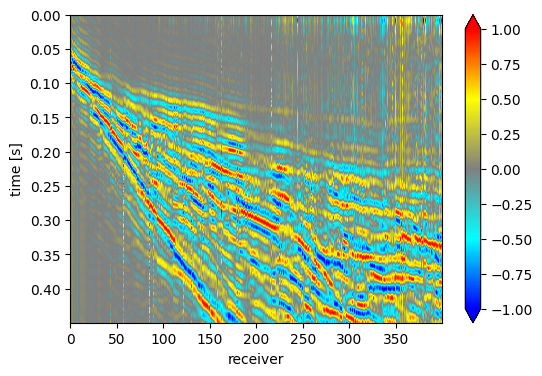

In [28]:
for trace in final: 
    trace.data /= np.max(abs(trace.data))

fig, ax = utils.plot_image(final, 1, cmap=cmap)
ax.invert_yaxis()



In [13]:
out_folder = "Field-Data/Acceleration-Data-SU"

s_x = np.arange(0,205,5) 

for i in range(len(s_x)):

    # stack the acceleration data 
    Nt, dt, data = stack_data(data_folder, paths, shot_locs, s_x[i])
    T = np.arange(0, Nt*dt, dt)

    # load template data   
    SU_template_path = "test_data/{:06d}/".format(i) + gahter_names
    temp = obspy.read(SU_template_path, format="SU")

    # interpolate data
    final = interpolate_data(temp, data, T)

    # write the displacement data
    out_path = out_folder + "/{:06d}/".format(i) + gahter_names
    final.write(out_path, format="SU")


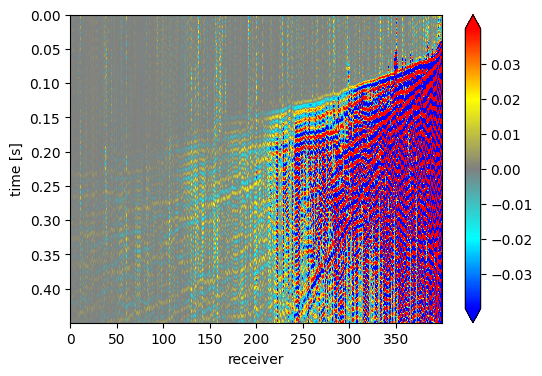

In [14]:
check = obspy.read(out_path, format="SU")
fig, ax = utils.plot_image(check, clip=0.001, cmap=cmap)
ax.invert_yaxis()